In [8]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
!pip install bayesian-optimization
!pip install catboost

  Stored in directory: /home/deepak/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization
     |████████████████████████████████| 61.8MB 295kB/s  eta 0:00:01
     |████████████████████████████████| 7.1MB 10.5MB/s eta 0:00:01
  Stored in directory: /home/deepak/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [5]:
import os
import gc
import numpy as np 
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from bayes_opt import BayesianOptimization
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc, precision_recall_curve

from sklearn import metrics
from sklearn import preprocessing
import catboost
from catboost import Pool

# Suppr warning
import warnings
warnings.filterwarnings("ignore")

import itertools
from scipy import interp

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

In [9]:
path = './data'
print(os.listdir(path))

path = './data/*'
os.system('cat {} > data1.zip'.format(path))  # recreate zip file

['data_split.zipaa', 'data_split.zipab', 'data_split.zipac']


0

In [11]:
os.system('unzip data1.zip -d data')  # unzip input data to data folder

2304

In [12]:
train_trans = pd.read_csv('data/train_transaction.csv')
test_trans = pd.read_csv('data/test_transaction.csv')
train_iden = pd.read_csv('data/train_identity.csv')
test_iden = pd.read_csv('data/test_identity.csv')

FileNotFoundError: [Errno 2] File b'data/train_transaction.csv' does not exist: b'data/train_transaction.csv'

In [0]:
train_trans.shape, test_trans.shape, train_iden.shape, test_iden.shape

((590540, 394), (506691, 393), (144233, 41), (141907, 41))

In [0]:
df_train = train_trans.merge(train_iden, on="TransactionID", how="left")
df_test = test_trans.merge(test_iden, on="TransactionID", how="left")

In [0]:
del train_iden, train_trans, test_iden, test_trans

gc.collect()

56

In [0]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


# Data Exploration

In [0]:
print(f'There are {df_train.isnull().any().sum()} columns in train dataset with missing values.')

There are 414 columns in train dataset with missing values.


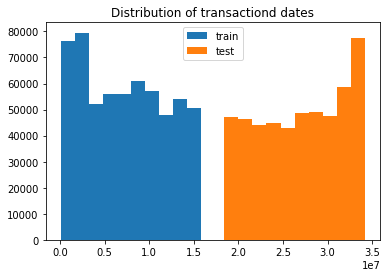

In [0]:
plt.hist(df_train['TransactionDT'], label='train');
plt.hist(df_test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');

In [0]:
df_train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64

# Cleaning

In [0]:
many_null_cols = [col for col in df_train.columns if df_train[col].isnull().sum() / df_train.shape[0] > 0.9]
many_null_cols_test = [col for col in df_test.columns if df_test[col].isnull().sum() / df_test.shape[0] > 0.9]

In [0]:
big_top_value_cols = [col for col in df_train.columns if df_train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in df_test.columns if df_test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [0]:
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

82

In [0]:
df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

In [0]:
print(f'There are {df_train.isnull().any().sum()} columns in train dataset with missing values.')

There are 333 columns in train dataset with missing values.


In [0]:
df_train.fillna(-999, inplace=True)
df_test.fillna(-999, inplace=True)

# Prepare data for modelling

In [0]:
# Label Encoding
for f in df_train.columns:
    if  df_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))
        
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [0]:
X_train = df_train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud']
X_test = df_test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
# del train
# test = df_test[["TransactionDT", 'TransactionID']]

# catboost

In [2]:
features = list(df_train)
features.remove('isFraud')
target = 'isFraud'

NameError: name 'df_train' is not defined

In [0]:
param_cb = {
        'learning_rate': 0.09445645065743215,
        'bagging_temperature': 0.39963209507789, 
        'l2_leaf_reg': int(22.165305913463673),
        'depth': int(7.920859337748043), 
        'max_leaves': 48,
        'max_bin':255,
        'iterations' : 1000,
        'task_type':'GPU',
        'loss_function' : "Logloss",
        'objective':'CrossEntropy',
        'eval_metric' : "AUC",
        'bootstrap_type' : 'Bayesian',
        'random_seed':1337,
        'early_stopping_rounds' : 100,
        'use_best_model':True 
    }

In [0]:
plt.rcParams["axes.grid"] = True

nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(df_train))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()


fold 1
0:	learn: 0.7496660	test: 0.7477082	best: 0.7477082 (0)	total: 68.5ms	remaining: 1m 8s
300:	learn: 0.9145193	test: 0.9076602	best: 0.9076602 (300)	total: 7.89s	remaining: 18.3s
600:	learn: 0.9301168	test: 0.9202312	best: 0.9202312 (600)	total: 15.5s	remaining: 10.3s
900:	learn: 0.9403711	test: 0.9285311	best: 0.9285337 (899)	total: 23.2s	remaining: 2.55s
999:	learn: 0.9429390	test: 0.9304538	best: 0.9304576 (998)	total: 25.9s	remaining: 0us
bestTest = 0.9304575622
bestIteration = 998
Shrink model to first 999 iterations.

fold 2
0:	learn: 0.7489384	test: 0.7512411	best: 0.7512411 (0)	total: 53.1ms	remaining: 53.1s
300:	learn: 0.9143882	test: 0.9104422	best: 0.9104422 (300)	total: 8.23s	remaining: 19.1s
600:	learn: 0.9301273	test: 0.9231165	best: 0.9231195 (599)	total: 16.7s	remaining: 11.1s
900:	learn: 0.9398624	test: 0.9306787	best: 0.9306787 (900)	total: 25.4s	remaining: 2.79s
999:	learn: 0.9422470	test: 0.9324107	best: 0.9324129 (998)	total: 28.2s	remaining: 0us
bestTest = 0

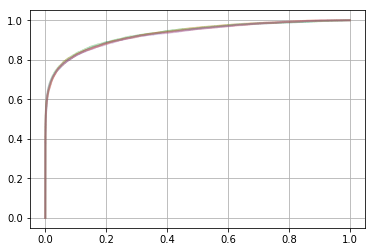

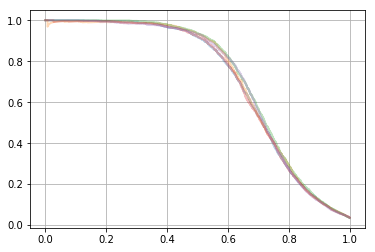

In [0]:
i = 1

for train_idx, valid_idx in skf.split(df_train, df_train.isFraud.values):
    print("\nfold {}".format(i))
    trn_data = Pool(df_train.iloc[train_idx][features].values,
                   label=df_train.iloc[train_idx][target].values
                   )
    val_data = Pool(df_train.iloc[valid_idx][features].values,
                   label=df_train.iloc[valid_idx][target].values
                   )   

    clf = catboost.train(trn_data, param_cb, eval_set= val_data, verbose = 300)

    oof[valid_idx]  = clf.predict(df_train.iloc[valid_idx][features].values)   
    oof[valid_idx]  = np.exp(oof[valid_idx]) / (1 + np.exp(oof[valid_idx]))
    
    predictions += clf.predict(df_test[features]) / nfold
    predictions = np.exp(predictions)/(1 + np.exp(predictions))
    
    # Scores 
    roc_aucs.append(roc_auc_score(df_train.iloc[valid_idx][target].values, oof[valid_idx]))
    accuracies.append(accuracy_score(df_train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(df_train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(df_train.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(df_train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Roc curve by fold
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(df_train.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))

    # Precion recall by folds
    g = plt.figure(2)
    precision, recall, _ = precision_recall_curve(df_train.iloc[valid_idx][target].values, oof[valid_idx])
    y_real.append(df_train.iloc[valid_idx][target].values)
    y_proba.append(oof[valid_idx])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))  
    
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(df_train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Features imp
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.get_feature_importance()
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

In [0]:
# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
    )


CV roc score        : 0.9310, std: 0.0015. 
CV accuracy score   : 0.9809, std: 0.0003. 
CV recall score     : 0.4874, std: 0.0061. 
CV precision score  : 0.9375, std: 0.0053. 
CV f1 score         : 0.6413, std: 0.0058.


In [0]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

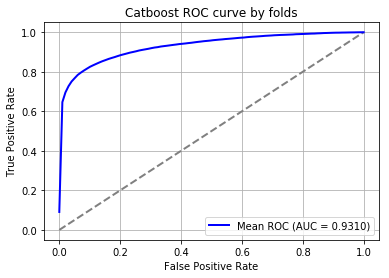

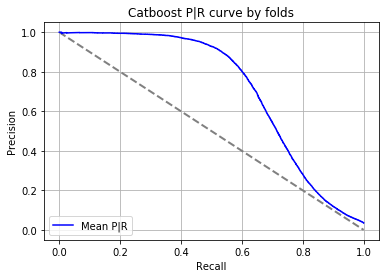

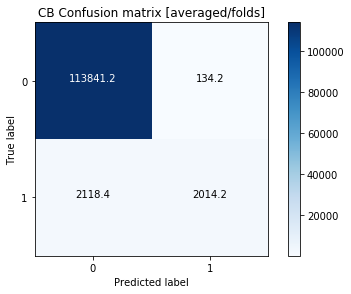

In [0]:
#ROC
f = plt.figure(1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Catboost ROC curve by folds')
plt.legend(loc="lower right")

# PR plt
g = plt.figure(2)
plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, color='blue',
         label=r'Mean P|R')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Catboost P|R curve by folds')
plt.legend(loc="lower left")

# Confusion maxtrix & metrics
plt.rcParams["axes.grid"] = False
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title= 'CB Confusion matrix [averaged/folds]')
plt.show()

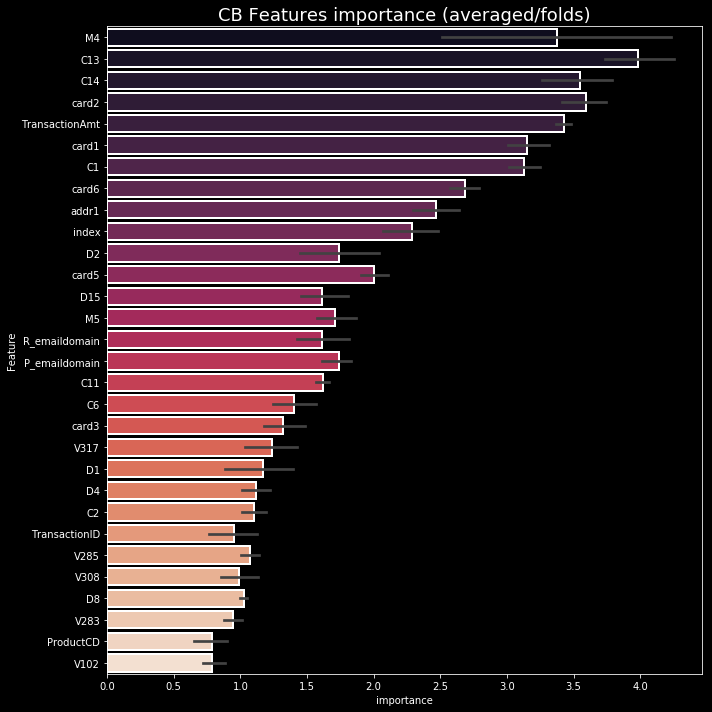

In [0]:
plt.style.use('dark_background')
cols = (feature_importance_df[["Feature", "importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False),
        edgecolor=('white'), linewidth=2, palette="rocket")
plt.title('CB Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()

In [0]:
sample_submission = pd.read_csv('data/sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = predictions
sample_submission.to_csv('submission_IEEE.csv')